In [1]:
import numpy as np
import cv2
import pandas as pd
from sklearn.metrics import accuracy_score
from lib.ReadFiles import read_csv
from lib.FaceDetection import find_faces
from lib.Prepocessing import image_equalizer
from lib.plot import *
from tensorflow.keras.models import load_model
import joblib

fisher = joblib.load("model/fisherface_training.pkl")
bpn = load_model("model/backprop_test.h5")

def reshape_dataset(X, y):
    images = [np.array(dx) for dx in X]
    images = np.asarray(images, dtype=np.uint8)
    labels = np.array(y).tolist()
    return images, labels
	
emotions = ["Marah", "Jijik", "Takut",
            "Senang", "Sedih", "Terkejut", "Biasa saja"]  # inisialisasi index dan emosi

In [2]:
_x, _y, _u = read_csv("input/fer2013_small.csv")
print(np.array(_x).shape)

x_new, y_new, u_new = [], [], []
for i, pixel in enumerate(_x):
	for norm, (x,y,w,h) in find_faces(np.array(pixel, dtype=np.uint8).reshape(48, 48)):
		if norm.size >0:
			x_new.append(pixel)
			y_new.append(_y[i])
			u_new.append(_u[i])
print(np.array(x_new).shape)

x_, y_ = image_equalizer(x_new, y_new)

(3815, 2304)
(1471, 2304)


In [3]:

dataframe = pd.DataFrame({"emotion": y_, "pixels": x_, "usage": u_new})

0.28222996515679444


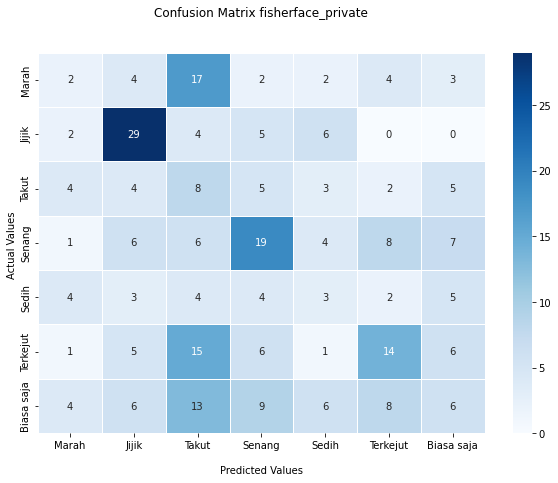

In [4]:
from tensorflow.keras.utils import to_categorical
_x_priv, _y_priv = dataframe.loc[dataframe["usage"].str.endswith("Test") ,"pixels"], dataframe.loc[dataframe["usage"].str.endswith("Test"), "emotion"]

x_priv, y_priv = reshape_dataset(_x_priv, _y_priv)

f_pred1 = []
f_extract1 = []
for i in range(len(x_priv)):
	_p = fisher.predict(x_priv[i]) #prediksi fisherface
	_q = fisher.extract(x_priv[i]) #ekstrasi fitur fisherface
	f_pred1.append(_p)
	f_extract1.append(_q)

print(accuracy_score(y_priv, f_pred1))
cm_plot(y_priv, f_pred1,'fisherface_private')

0.15444015444015444


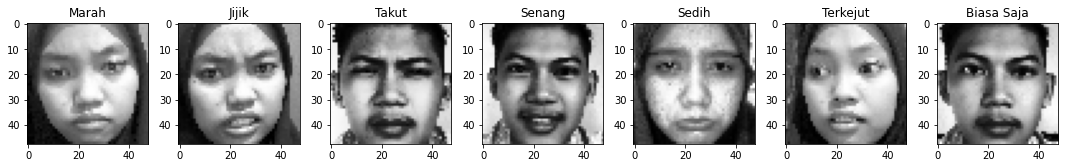

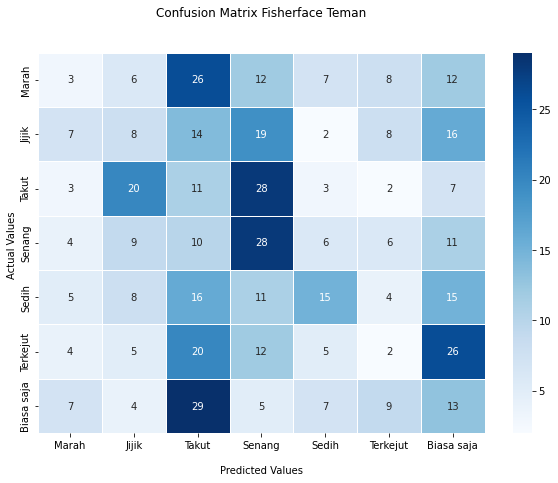

17/17 [==============================] - 0s 1ms/step - loss: 0.1888 - accuracy: 0.1409


[0.18881762027740479, 0.14092664420604706]

In [5]:
# membaca datatest Teman
_x_teman, _y_teman = read_csv("input/datatest_prib.csv")

x_teman, y_teman = reshape_dataset(_x_teman, _y_teman)

x_teman, y_teman = image_equalizer(x_teman, y_teman)
plot_figure(x_teman, y_teman)

f_pred3 = []
f_extract3 = []
for i in range(len(x_teman)):
	_p = fisher.predict(x_teman[i]) #prediksi fisherface
	_q = fisher.extract(x_teman[i]) #ekstrasi fitur fisherface
	f_pred3.append(_p)
	f_extract3.append(_q)

print(accuracy_score(y_teman, f_pred3))
cm_plot(y_teman, f_pred3, 'Fisherface Teman')

bpn.evaluate(np.asarray(f_extract3, dtype=np.float32).reshape(len(f_extract3), -1), to_categorical(y_teman))

In [6]:
from lib.Backpropagation import ModelBackprop

bpn = ModelBackprop(x = None, y = None, n_hidden=128, lr=0.25)

Num GPUs Available:  0


In [9]:
bpn.model.compile(loss="MSE", optimizer='sgd', metrics=['accuracy'])
hst = bpn.model.fit(np.asarray(f_extract1, dtype=np.float32).reshape(len(f_extract1), -1), to_categorical(y_priv),  validation_data=(np.asarray(f_extract3, dtype=np.float32).reshape(len(f_extract3), -1), to_categorical(y_teman)),epochs=1000, batch_size=1)

Epoch 1/1000
287/287 [==============================] - 1s 2ms/step - loss: 0.1100 - accuracy: 0.3519 - val_loss: 0.1296 - val_accuracy: 0.1815
Epoch 2/1000
287/287 [==============================] - 1s 2ms/step - loss: 0.1099 - accuracy: 0.3136 - val_loss: 0.1301 - val_accuracy: 0.1834
Epoch 3/1000
287/287 [==============================] - 1s 2ms/step - loss: 0.1099 - accuracy: 0.3380 - val_loss: 0.1300 - val_accuracy: 0.1795
Epoch 4/1000
287/287 [==============================] - 1s 2ms/step - loss: 0.1098 - accuracy: 0.3415 - val_loss: 0.1301 - val_accuracy: 0.1795
Epoch 5/1000
287/287 [==============================] - 1s 2ms/step - loss: 0.1097 - accuracy: 0.3484 - val_loss: 0.1303 - val_accuracy: 0.1834
Epoch 6/1000
287/287 [==============================] - 1s 2ms/step - loss: 0.1096 - accuracy: 0.3484 - val_loss: 0.1301 - val_accuracy: 0.1853
Epoch 7/1000
287/287 [==============================] - 1s 2ms/step - loss: 0.1095 - accuracy: 0.3449 - val_loss: 0.1303 - val_accuracy:

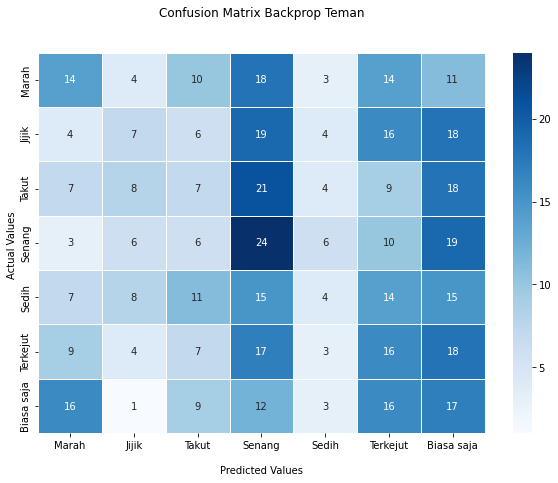

In [10]:
predict = bpn.predict(np.asarray(f_extract3, dtype=np.float32).reshape(len(f_extract3), -1))
cm_plot(y_teman, np.argmax(predict, axis=1), 'Backprop Teman')

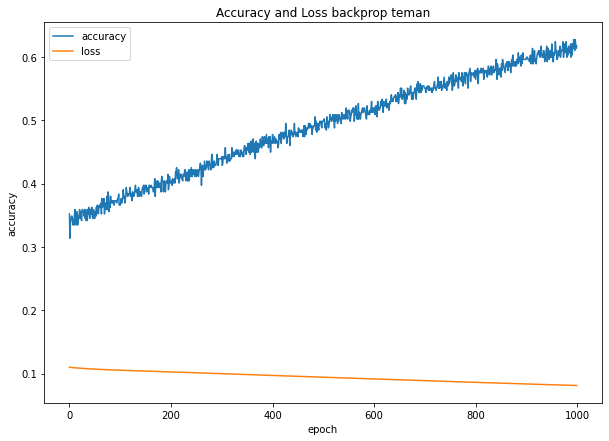

In [11]:
history_plot(hst, "backprop teman")